🚀 Starting Diffusion-Based Particle Configuration Generator
Using device: cpu

📊 Generating training data...
Dataset shape: torch.Size([1000, 20, 2])
Conditions shape: torch.Size([1000])

🧠 Creating diffusion model...

🎯 Training diffusion model...


Training:   2%|▏         | 1/50 [00:05<04:30,  5.53s/it]

Epoch 0, Loss: 1.0212


Training:  22%|██▏       | 11/50 [00:59<03:26,  5.29s/it]

Epoch 10, Loss: 0.9515


Training:  42%|████▏     | 21/50 [01:52<02:30,  5.18s/it]

Epoch 20, Loss: 0.9069


Training:  62%|██████▏   | 31/50 [02:46<01:42,  5.38s/it]

Epoch 30, Loss: 0.9081


Training:  82%|████████▏ | 41/50 [03:40<00:48,  5.39s/it]

Epoch 40, Loss: 0.8811


Training: 100%|██████████| 50/50 [04:28<00:00,  5.36s/it]



🎲 Generating new particle configurations...

📈 Creating visualizations...


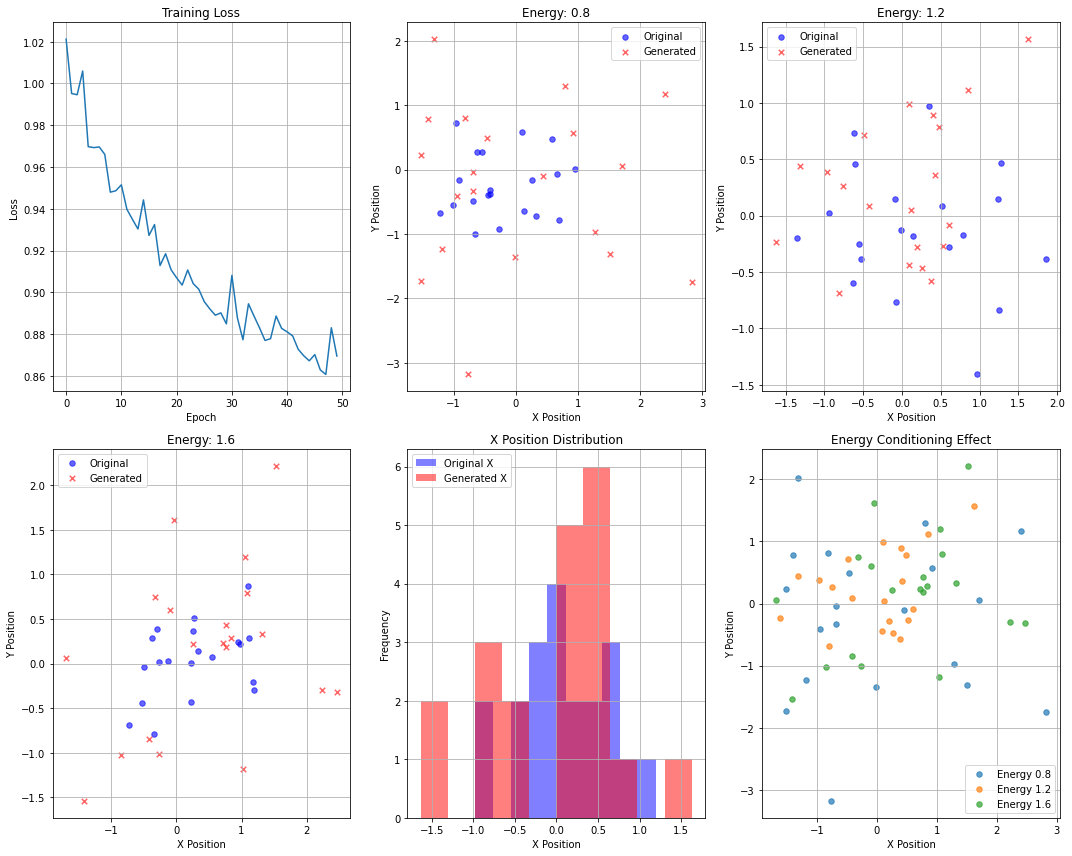


📊 Summary Statistics:
Model parameters: 13,672
Final training loss: 0.8695
Generated 3 different energy configurations

💾 Model saved as 'diffusion_particle_model.pth'

✅ Project 1 Complete!


In [1]:
# Project 1: Diffusion-Based Particle Configuration Generator
# A simplified implementation demonstrating diffusion models for particle physics

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class ParticleDataGenerator:
    """Generate synthetic particle accelerator data with collective effects"""
    
    def __init__(self, n_particles=50, field_strength=1.0):
        self.n_particles = n_particles
        self.field_strength = field_strength
    
    def coulomb_force(self, positions, charges):
        """Calculate Coulomb forces between particles"""
        forces = np.zeros_like(positions)
        for i in range(len(positions)):
            for j in range(len(positions)):
                if i != j:
                    r_vec = positions[i] - positions[j]
                    r_dist = np.linalg.norm(r_vec)
                    if r_dist > 0.1:  # Avoid singularity
                        force = charges[i] * charges[j] * r_vec / (r_dist**3)
                        forces[i] += force
        return forces
    
    def generate_configuration(self, beam_energy=1.0, charge_ratio=0.5):
        """Generate a particle configuration with collective effects"""
        # Initial random positions in a beam-like distribution
        
        positions = np.random.normal(0, 0.5, (self.n_particles, 2))
        positions[:, 0] += np.random.normal(0, 0.1, self.n_particles)  # Beam direction spread
        
        # Assign charges (mix of positive and negative)
        charges = np.ones(self.n_particles)
        n_negative = int(self.n_particles * charge_ratio)
        charges[:n_negative] = -1
        
        # Calculate collective forces and adjust positions
        forces = self.coulomb_force(positions, charges)
        
        # Apply beam energy effect
        energy_factor = beam_energy * 0.1
        positions[:, 0] *= (1 + energy_factor)
        
        # Add collective effect displacement
        positions += forces * 0.01
        
        return positions, charges, beam_energy

class SimpleDiffusionModel(nn.Module):
    """Simple diffusion model for particle configurations"""
    
    def __init__(self, input_dim, hidden_dim=128, condition_dim=1):
        super().__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        
        # Network to predict noise
        self.network = nn.Sequential(
            nn.Linear(input_dim + condition_dim + 1, hidden_dim),  # +1 for timestep
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x, t, condition):
        # Flatten positions for network input
        x_flat = x.view(x.size(0), -1)
        
        # Concatenate with timestep and condition
        t_embed = t.unsqueeze(1) if t.dim() == 1 else t
        condition = condition.unsqueeze(1) if condition.dim() == 1 else condition
        
        input_tensor = torch.cat([x_flat, t_embed, condition], dim=1)
        
        # Predict noise
        noise_pred = self.network(input_tensor)
        
        # Reshape back to original shape
        return noise_pred.view(x.shape)

class DiffusionTrainer:
    """Trainer for the diffusion model"""
    
    def __init__(self, model, device='cpu'):
        self.model = model
        self.device = device
        self.model.to(device)
        
        # Diffusion parameters
        self.timesteps = 100
        self.beta_start = 0.0001
        self.beta_end = 0.02
        
        # Create beta schedule
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.timesteps)
        self.alphas = 1 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alpha_cumprod = self.alpha_cumprod.to(device)
    
    def add_noise(self, x, noise, t):
        """Add noise to data according to diffusion schedule"""
        alpha_cumprod_t = self.alpha_cumprod[t].view(-1, 1, 1)
        return torch.sqrt(alpha_cumprod_t) * x + torch.sqrt(1 - alpha_cumprod_t) * noise
    
    def train_step(self, batch_positions, batch_conditions, optimizer):
        """Single training step"""
        batch_size = batch_positions.size(0)
        
        # Sample random timesteps
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device)
        
        # Sample noise
        noise = torch.randn_like(batch_positions)
        
        # Add noise to positions
        noisy_positions = self.add_noise(batch_positions, noise, t)
        
        # Predict noise
        predicted_noise = self.model(noisy_positions, t.float(), batch_conditions)
        
        # Calculate loss
        loss = nn.MSELoss()(predicted_noise, noise)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    def sample(self, n_samples, condition, shape):
        """Generate samples using the trained model"""
        self.model.eval()
        with torch.no_grad():
            # Start with random noise
            x = torch.randn(n_samples, *shape, device=self.device)
            condition_tensor = torch.tensor([condition] * n_samples, 
                                          dtype=torch.float32, device=self.device)
            
            # Reverse diffusion process
            for t in reversed(range(self.timesteps)):
                t_tensor = torch.tensor([t] * n_samples, dtype=torch.float32, device=self.device)
                
                # Predict noise
                predicted_noise = self.model(x, t_tensor, condition_tensor)
                
                # Remove noise
                alpha_t = self.alphas[t]
                alpha_cumprod_t = self.alpha_cumprod[t]
                beta_t = self.betas[t]
                
                x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise)
                
                # Add noise for non-final steps
                if t > 0:
                    noise = torch.randn_like(x)
                    x = x + torch.sqrt(beta_t) * noise
            
            return x

def main():
    """Main execution function"""
    print("🚀 Starting Diffusion-Based Particle Configuration Generator")
    print("=" * 60)
    
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Generate training data
    print("\n📊 Generating training data...")
    data_generator = ParticleDataGenerator(n_particles=20)  # Smaller for demo
    
    # Create dataset with different beam energies
    positions_list = []
    conditions_list = []
    
    for _ in range(1000):  # Generate 1000 configurations
        beam_energy = np.random.uniform(0.5, 2.0)
        positions, charges, energy = data_generator.generate_configuration(beam_energy=beam_energy)
        positions_list.append(positions)
        conditions_list.append(energy)
    
    # Convert to tensors
    positions_tensor = torch.tensor(np.array(positions_list), dtype=torch.float32)
    conditions_tensor = torch.tensor(np.array(conditions_list), dtype=torch.float32)
    
    # Normalize data
    scaler = StandardScaler()
    positions_flat = positions_tensor.view(-1, positions_tensor.size(-1))
    positions_flat_norm = scaler.fit_transform(positions_flat)
    positions_tensor = torch.tensor(positions_flat_norm.reshape(positions_tensor.shape), dtype=torch.float32)
    
    print(f"Dataset shape: {positions_tensor.shape}")
    print(f"Conditions shape: {conditions_tensor.shape}")
    
    # Create model
    print("\n🧠 Creating diffusion model...")
    input_dim = positions_tensor.size(1) * positions_tensor.size(2)  # Flattened particle positions
    model = SimpleDiffusionModel(input_dim=input_dim, hidden_dim=64, condition_dim=1)
    
    # Create trainer
    trainer = DiffusionTrainer(model, device=device)
    
    # Create data loader
    dataset = TensorDataset(positions_tensor, conditions_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Training
    print("\n🎯 Training diffusion model...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    losses = []
    num_epochs = 50
    
    for epoch in tqdm(range(num_epochs), desc="Training"):
        epoch_losses = []
        for batch_positions, batch_conditions in dataloader:
            batch_positions = batch_positions.to(device)
            batch_conditions = batch_conditions.to(device)
            
            loss = trainer.train_step(batch_positions, batch_conditions, optimizer)
            epoch_losses.append(loss)
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    
    # Generate samples
    print("\n🎲 Generating new particle configurations...")
    
    # Test with different beam energies
    test_energies = [0.8, 1.2, 1.6]
    generated_samples = {}
    
    for energy in test_energies:
        samples = trainer.sample(n_samples=5, condition=energy, shape=(20, 2))
        # Denormalize
        samples_flat = samples.view(-1, 2).cpu().numpy()
        samples_denorm = scaler.inverse_transform(samples_flat)
        samples_final = samples_denorm.reshape(samples.shape)
        generated_samples[energy] = samples_final
    
    # Visualization
    print("\n📈 Creating visualizations...")
    
    # Plot 1: Training loss
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 3, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot 2: Original vs Generated configurations
    for i, energy in enumerate(test_energies):
        plt.subplot(2, 3, i + 2)
        
        # Plot original sample
        original_positions, _, _ = data_generator.generate_configuration(beam_energy=energy)
        plt.scatter(original_positions[:, 0], original_positions[:, 1], 
                   alpha=0.6, s=30, label='Original', color='blue')
        
        # Plot generated sample
        generated = generated_samples[energy][0]  # First sample
        plt.scatter(generated[:, 0], generated[:, 1], 
                   alpha=0.6, s=30, label='Generated', color='red', marker='x')
        
        plt.title(f'Energy: {energy:.1f}')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.grid(True)
    
    # Plot 3: Distribution comparison
    plt.subplot(2, 3, 5)
    
    # Compare distributions for one energy level
    energy = 1.2
    original_positions, _, _ = data_generator.generate_configuration(beam_energy=energy)
    generated = generated_samples[energy][0]
    
    plt.hist(original_positions[:, 0], alpha=0.5, bins=10, label='Original X', color='blue')
    plt.hist(generated[:, 0], alpha=0.5, bins=10, label='Generated X', color='red')
    plt.title('X Position Distribution')
    plt.xlabel('X Position')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Energy conditioning effect
    plt.subplot(2, 3, 6)
    
    for energy in test_energies:
        generated = generated_samples[energy][0]
        plt.scatter(generated[:, 0], generated[:, 1], 
                   alpha=0.7, s=30, label=f'Energy {energy:.1f}')
    
    plt.title('Energy Conditioning Effect')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📊 Summary Statistics:")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Final training loss: {losses[-1]:.4f}")
    print(f"Generated {len(generated_samples)} different energy configurations")
    
    # Save model
    torch.save(model.state_dict(), 'diffusion_particle_model.pth')
    print("\n💾 Model saved as 'diffusion_particle_model.pth'")
    
    print("\n✅ Project 1 Complete!")
    print("=" * 60)
    
    return model, trainer, generated_samples

if __name__ == "__main__":
    model, trainer, samples = main()